# C23-PR588 AUD/IDR DNN MODEL 

Import necessary libraries

In [22]:
%run helper_functions_and_libraries.py
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [23]:
CURRENCIES_CSV = './currency_data_10_years.csv'

# Create dataframe by using datas from csv file
currencies_df = pd.read_csv(CURRENCIES_CSV)

# Create new dataframe containing ONLY needed data for the model
aud_idr_df = currencies_df[['date', 'AUD']]

# Displaying the first and last 5 row of data to understand the contents of the data
display(aud_idr_df.head())
display(aud_idr_df.tail())

,date,AUD
0,2013-05-01,9991.932116
1,2013-05-02,9976.629029
2,2013-05-03,10024.671009
3,2013-05-04,10037.051582
4,2013-05-05,9999.337595


,date,AUD
3648,2023-04-27,9743.131115
3649,2023-04-28,9706.330826
3650,2023-04-29,9696.280669
3651,2023-04-30,9699.881962
3652,2023-05-01,9719.609412


Each data point is composed of the date and the recorded exchange rate from AUD to IDR

## Parsing the raw data
Read the data from the csv file and Creating global (G) dataclass

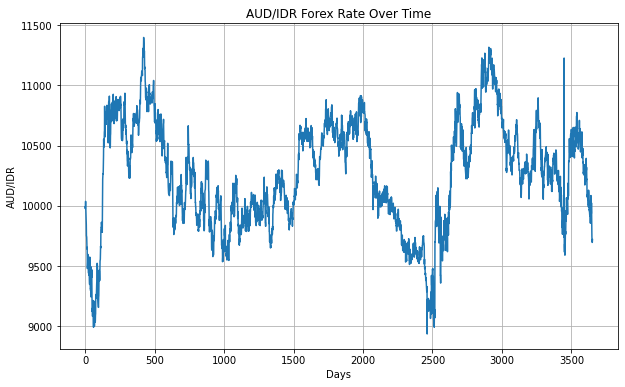

In [24]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    
    DATAFRAME = aud_idr_df
    times, values = parse_data_from_df(DATAFRAME, 'AUD')
    TIME = times
    SERIES = values
    SPLIT_TIME = 3200
    WINDOW_SIZE = 30
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, title="AUD/IDR Forex Rate Over Time", xlabel="Days", ylabel="AUD/IDR")

## Processing the data

train_val_split and windowed_dataset functions taken from 'tensorflow-sequences-time-series-and-prediction' courses in Coursera

In [25]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME)

In [26]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

## Defining the model architecture

In [27]:
def create_model():
    
    # Build the model
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Dense(30, input_shape=[G.WINDOW_SIZE], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)

    ])

    return model

In [28]:
# Create and test model
model = create_model()

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Adjusting the learning rate

In [30]:
def adjust_learning_rate(dataset, model_to_train):

    model = model_to_train

    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    
    # Select optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer)
    
    # Train the model
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [31]:
# Run the training with dynamic LR
history = adjust_learning_rate(train_set, model)

Epoch 1/100
100/100 [==============================] - 1s 4ms/step - loss: 7489.1636 - lr: 1.0000e-08
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 93.5976 - lr: 1.1220e-08
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 90.8524 - lr: 1.2589e-08
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 90.1615 - lr: 1.4125e-08
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 89.9248 - lr: 1.5849e-08
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 88.6457 - lr: 1.7783e-08
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 91.2712 - lr: 1.9953e-08
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 95.8913 - lr: 2.2387e-08
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 93.4221 - lr: 2.5119e-08
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 93.1410 - lr: 2.8184e-

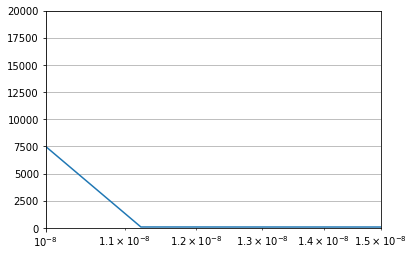

In [32]:
# Plot the loss in log scale
plt.semilogx(history.history["lr"], history.history["loss"])

# Set the plot boundaries
plt.axis([1e-8, 1.5e-8, 0, 20000])

# Set the grid
plt.grid(True)

In [33]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Compiling the model

In [34]:
def compile_model(dataset, model_to_train):

    model = model_to_train

    # Select optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
        
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
        
    # Train the model
    history = model.fit(dataset, epochs=100)

    return history

In [35]:
history = compile_model(train_set, model)

Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 7478.4355 - mae: 7478.9351
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 91.1576 - mae: 91.6571
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 88.1684 - mae: 88.6677
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 90.0531 - mae: 90.5513
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 88.8625 - mae: 89.3616
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 92.5183 - mae: 93.0167
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 89.4290 - mae: 89.9273
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 91.9591 - mae: 92.4574
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 91.4835 - mae: 91.9824
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 90.0927 - mae: 90.5910
Epoch 11/100
10

## Visualize MAE and loss

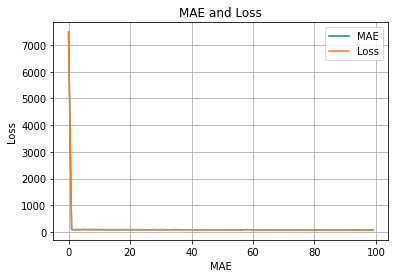

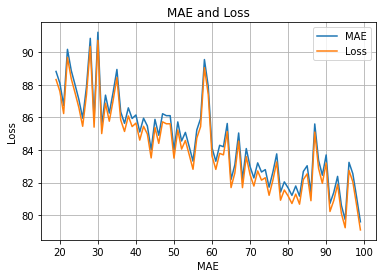

In [36]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    time=epochs, 
    series=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    time=epochs_zoom, 
    series=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Evaluating the forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - 0s 4ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the 

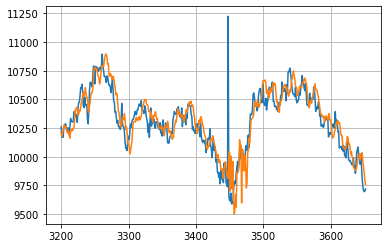

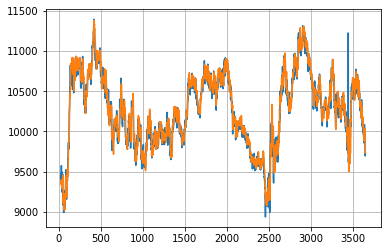

In [37]:
# Slice the forecast to get only the predictions for the validation set
dnn_forecast_valid_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Compute the forecast for all the series
dnn_forecast_valid = model_forecast(model, dnn_forecast_valid_series, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
dnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()

# Plot the forecast
plot_series(time_valid, (series_valid, dnn_forecast_valid))
plot_series(G.TIME[G.WINDOW_SIZE-1:], (G.SERIES[G.WINDOW_SIZE-1:], dnn_forecast))

In [38]:
compute_metrics(series_valid, dnn_forecast_valid)

{'mae': array([215.12547, 251.61728, 251.61877, 251.50023, 212.4777 , 213.93324,
        209.28177, 210.39706, 225.89035, 223.15802, 217.41461, 237.94766,
        239.03658, 213.1803 , 203.58696, 206.01544, 206.00401, 206.5382 ,
        205.07266, 209.1602 , 208.8137 , 203.6148 , 204.05983, 205.25662,
        207.07124, 217.65044, 231.75403, 233.5462 , 259.31665, 301.67337,
        301.507  , 323.64862, 273.45718, 220.28835, 217.11862, 252.70818,
        223.07318, 223.01921, 225.634  , 203.82593, 209.44705, 209.69624,
        280.74466, 336.7942 , 336.7249 , 320.13956, 305.43372, 386.16296,
        465.12875, 462.42236, 326.68414, 460.22803, 454.45425, 455.55606,
        448.1895 , 420.22714, 431.30304, 452.3438 , 452.54547, 431.26038,
        482.1134 , 566.8277 , 468.30673, 427.57288, 379.15366, 379.2044 ,
        374.92993, 336.43613, 385.22003, 380.20996, 342.29892, 317.7185 ,
        317.65894, 303.94208, 274.81897, 315.34213, 366.97888, 293.0939 ,
        236.1429 , 232.52013, 2

In [39]:
print(f'2 last Actual Price = {series_valid[-2:]}, Predicted Price = {dnn_forecast_valid[-2:]}')

2 last Actual Price = [[9699.881962]
 [9719.609412]], Predicted Price = [9794.275 9759.833]


## Future Predictions

In [40]:
into_future = 100

future_forecast = make_future_forecast(values=G.SERIES,
                                       model=model,
                                       into_future=into_future,
                                       window_size=G.WINDOW_SIZE)

1/1 [==============================] - 0s 21ms/step
Predicting on:
 [[ 9991.164594]
 [10129.656911]
 [10112.958701]
 [10052.054014]
 [ 9973.110625]
 [ 9965.620727]
 [ 9968.598951]
 [ 9950.687169]
 [ 9947.506228]
 [ 9927.536872]
 [ 9940.046811]
 [ 9991.557014]
 [ 9913.167687]
 [ 9917.60924 ]
 [ 9856.107891]
 [ 9961.256773]
 [10040.224458]
 [10066.447283]
 [10085.21644 ]
 [ 9995.16504 ]
 [ 9995.165155]
 [ 9935.947873]
 [10023.99686 ]
 [ 9915.824429]
 [ 9812.169065]
 [ 9743.131115]
 [ 9706.330826]
 [ 9696.280669]
 [ 9699.881962]
 [ 9719.609412]] -> Prediction: 9730.4814453125

1/1 [==============================] - 0s 47ms/step
Predicting on:
 [10129.656911   10112.958701   10052.054014    9973.110625
  9965.620727    9968.598951    9950.687169    9947.506228
  9927.536872    9940.046811    9991.557014    9913.167687
  9917.60924     9856.107891    9961.256773   10040.224458
 10066.447283   10085.21644     9995.16504     9995.165155
  9935.947873   10023.99686     9915.824429    9812.1690

In [41]:
start_future = G.TIME[-1] + 1
future_time = np.arange(start_future, start_future + into_future)

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
future_time = np.insert(future_time, 0, G.TIME[-1])
future_forecast = np.insert(future_forecast, 0, G.SERIES[-1])

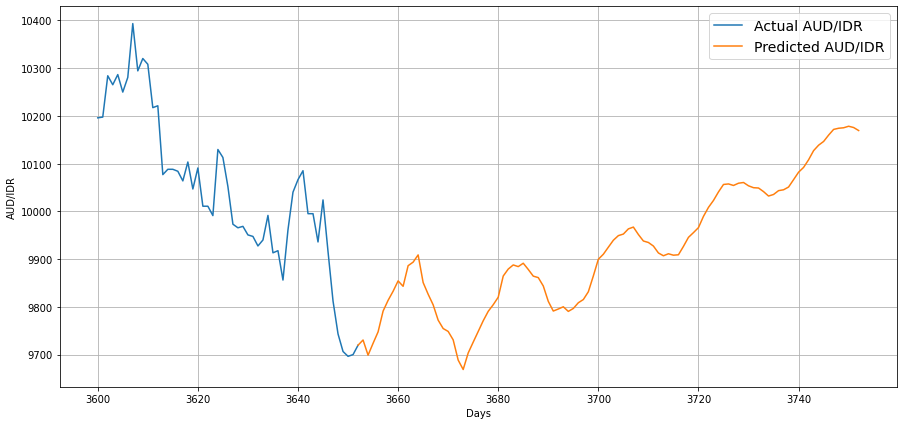

In [42]:
plt.figure(figsize=(15,7))
plot_future_forecast(G.TIME, G.SERIES, start=3600, format="-", label="Actual AUD/IDR", xlabel="Days", ylabel="AUD/IDR")
plot_future_forecast(future_time, future_forecast, format="-", label="Predicted AUD/IDR", xlabel="Days", ylabel="AUD/IDR")

### Model is unstable and mostly overfitted, the MAE is over 100 which make this model a bad model